In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tnrange
%matplotlib inline

In [2]:
class Bandit:

    
    def __init__(self, k_arm=10, epsilon=0.0, initial=0.0, step_size=0.1):
        self.k = k_arm
        self.step_size = step_size
        self.indices = np.arange(self.k)
        self.time = 0
        self.average_reward = 0
        self.epsilon = epsilon
        self.initial = initial

        
    def reset(self):
        # real reward for each action
        self.q_true = np.random.randn(self.k)

        # estimation for each action
        self.q_estimation = np.zeros(self.k) + self.initial

        # Number of chosen times for each action
        self.action_count = np.zeros(self.k)

        self.best_action = np.argmax(self.q_true)
        self.time = 0
   

    def act(self):
        """
        Get an action for this bandit
        """
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.indices)

        q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])

    
    def step(self, action):
        """
        Take an action, update estimation for this action using a constant step size
        """
        # Produce a reward using N(µ=true reward, σ^2=1)
        reward = np.random.randn() + self.q_true[action]
        # Increment counters
        self.time += 1
        self.action_count[action] += 1
        # Update average reward received metric
        self.average_reward += (reward - self.average_reward) / self.time
        return reward
    
    
class SampleAverageActionValue:
    
    def __init__(self, bandit):
        self.bandit = bandit
        self.name = "Sample Average Action Value"

        
    def reset(self):
        self.bandit.reset()
        self.best_action = self.bandit.best_action

         
    def act(self):
        return self.bandit.act()       
        
    
    def step(self, action):
        reward = self.bandit.step(action)
        self.bandit.q_estimation[action] += (reward - self.bandit.q_estimation[action]) / self.bandit.action_count[action]
        return reward
    
    
class ConstantStepActionValue:
    
    def __init__(self, bandit):
        self.bandit = bandit
        self.name = "Constant Step Action Value"
        

    def reset(self):
        self.bandit.reset()
        self.best_action = self.bandit.best_action

        
    def act(self):
        return self.bandit.act()
    
        
    def step(self, action):
        reward = self.bandit.step(action)
        self.bandit.q_estimation[action] += self.bandit.step_size * (reward - self.bandit.q_estimation[action])
        return reward

In [3]:
import threading


def simulate(runs, time, bandits):
    """
    This still needs to be parallelized in a better way (The global shared lock is inefficient)
    Implement in a thread pool and split among bandits to capitalize on all host machine cores.
    """
    
    lock = threading.Lock()
    rewards = np.zeros((len(bandits), runs, time))
    best_action_counts = np.zeros(rewards.shape)
    
    
    def work(runs, time, bandit, idx):
        for run in tnrange(runs):
            bandit.reset()
            for t in range(time):
                action = bandit.act()
                reward = bandit.step(action)
                
                with lock:
                    rewards[idx, run, t] = reward
                    if action == bandit.best_action:
                        best_action_counts[idx, run, t] = 1
    

    threads = list()
    for i, bandit in enumerate(bandits):
        t = threading.Thread(target=work, args=(runs, time, bandit, i))
        threads.append(t)
        t.start()
        
                             
    for idx, thread in enumerate(threads):
        thread.join()

    mean_best_action_counts = best_action_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)
    return mean_best_action_counts, mean_rewards

# Violin Plot
---

Text(0, 0.5, 'Reward Distribution')

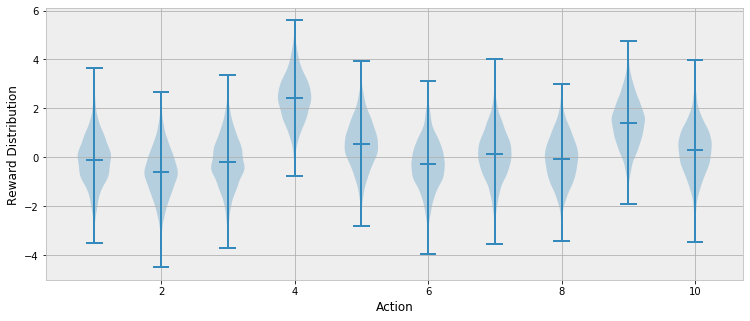

In [4]:
plt.figure(figsize=(12.5, 5))
plt.violinplot(dataset=np.random.randn(2000, 10) + np.random.randn(10), showmeans=True)
plt.xlabel("Action")
plt.ylabel("Reward Distribution")

# Figure 2.2
---

In [5]:
# If you only see HBOX HTML text output then run Jupyter notebook from project root to get progress bars
runs = 2000
time = 1000
epsilons = [0, 0.1, 0.01]
bandits = [SampleAverageActionValue(Bandit(epsilon=eps)) for eps in epsilons]
best_action_counts, rewards = simulate(runs, time, bandits)

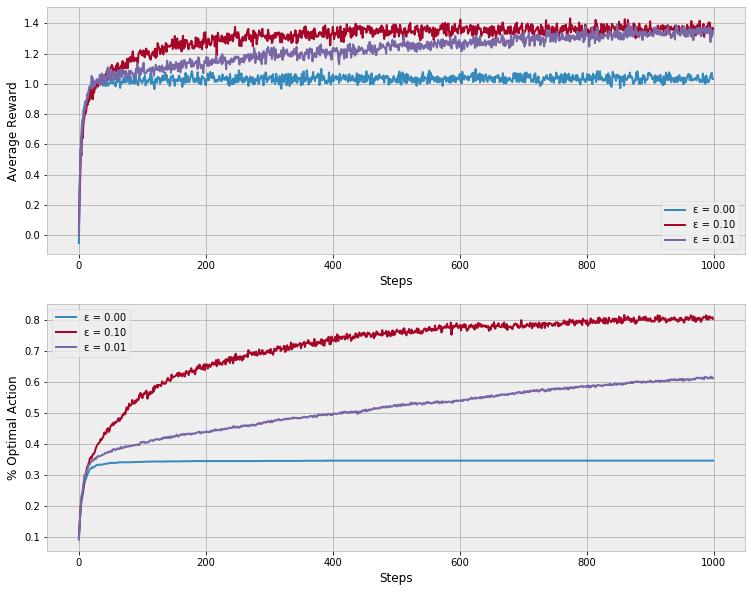

In [6]:
plt.figure(figsize=(12.5, 10))

plt.subplot(2, 1, 1)
for eps, rewards in zip(epsilons, rewards):
    plt.plot(rewards, label='ε = %.02f' % (eps))
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.legend()

plt.subplot(2, 1, 2)
for eps, counts in zip(epsilons, best_action_counts):
    plt.plot(counts, label='ε = %.02f' % (eps))
plt.xlabel('Steps')
plt.ylabel('% Optimal Action')
plt.legend()

## Exercise 2.4
---
If the step-size parameters, $ \propto_n $, are not constant, then the estimate $ Q_n $ is a weighted average of previously received rewards with a weighting different from that given by (2.6). What is the weighting on each prior reward for the general case, analogous to (2.6), in terms of the sequence of step-size parameters?  

\begin{equation*}
Q_{n+1}=(1 - \propto)^n Q_1 + \sum_{i=1}^{n}\propto(1-\propto)^{n-i}R_i \tag{2.6}
\end{equation*}

### Solution:
---
Let $ \propto_{n}(a) $ vary with time:

\begin{align*}
Q_{n+1}
&= Q_n + \propto_n[R_n - Q_n] \\
&= (1 - \propto_n)Q_n + \propto_nR_n \\
&= (1 - \propto_n)(\propto_{n-1}R_{n-1} + (1 - \propto_{n-1})Q_{n-1}) + \propto_nR_n \\
&= (1 - \propto_n)\propto_{n-1}R_{n-1} + (1 - \propto_n)(1 - \propto_{n-1})Q_{n-1} + \propto_nR_n \\
&= (1 - \propto_n)\propto_{n-1}R_{n-1} + (1 - \propto_n)^2\propto_nR_{n-2} + ... + (1 - \propto_n)^{n-1}\propto_nR_1  + (1 - \propto_n)^nQ_1 + \propto_nR_n \\
&= Q_1\prod_{i=1}^n(1 - \propto_i) + \sum_{i=1}^n(\propto_iR_i\prod_{j=i}^n(1 - \propto_j))
\end{align*}



## Exercise 2.5
---
Design and conduct an experiment to demonstrate the difficulties that sample-average methods have for nonstationary problems. Use a modified version of the 10-armed testbed in which all the $ q_{*}(a) $ start out equal and then take independent random walks (say by adding a normally distributed increment with mean zero and standard deviation 0.01 to all the $ q_{*}(a) $ on each step).

Prepare plots like Figure 2.2 for an action-value method using sample averages, incrementally computed, and another action-value method using a constant step-size parameter, $ \propto=0.1 $. Use $ \epsilon=0.1 $ and longer runs, say of 10,000 steps.

In [7]:
class NonStationaryBandit(Bandit):
    
    def __init__(self, k_arm=10, epsilon=0.0, initial=0.0, step_size=0.1):
        super().__init__(k_arm, epsilon, initial, step_size)
    
    
    def reset(self):
        Bandit.reset(self)
        # real reward for each action (Start out equal)
        self.q_true = np.zeros(self.k) + self.initial
    
    
    def step(self, action):
        """ Each step have q*(a) take random walk sampled from N(µ=0, σ^2=0.01)"""
        reward = Bandit.step(self, action)
        # Increment all rewards to take a random walk
        µ = 0
        σ = 0.1 # sqrt σ^2
        self.q_true += σ * np.random.randn(self.q_estimation.size) + µ
        return reward

In [ ]:
# If you only see HBOX HTML text output then run Jupyter notebook from project root to get progress bars
runs = 1000
time = 10000
initial_reward = 0
bandits = [ SampleAverageActionValue(NonStationaryBandit(epsilon=0.1, initial=initial_reward)),
            ConstantStepActionValue(NonStationaryBandit(epsilon=0.1, step_size=0.1, initial=initial_reward))
          ]
best_action_counts, rewards = simulate(runs, time, bandits)

In [ ]:
plt.figure(figsize=(12.5, 10))

plt.subplot(2, 1, 1)
for bandit, rewards in zip(bandits, rewards):
    plt.plot(rewards, label='bandit = %s' % (bandit.name))
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.legend()

plt.subplot(2, 1, 2)
for bandit, counts in zip(bandits, best_action_counts):
    plt.plot(counts, label='bandit = %s' % (bandit.name))
plt.xlabel('Steps')
plt.ylabel('% Optimal Action')
plt.legend()